In [1]:
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

from python import classes, metrics, data_loader

In [2]:
notebook_classification = ""
notebook_cv = 0

image_size = 64
batch_size = 64
max_epochs = 300
lr_scheduler_patience = 10
early_stopping_patience = 15
total_cv = 5

data_dir = "data"
tensorboard_dir = "out/logs"
metrics_dir = "out/metrics"
models_dir = "out/keras"
weights_dir = "out/weights"

In [3]:
# Parameters
notebook_classification = "models"
notebook_cv = 1


In [4]:
assert notebook_classification in ['models', 'types'], "notebook_classification must be one of ['models', 'types']"
assert notebook_cv != 0, "notebook_cv must be provided"
assert 1 <= notebook_cv <= total_cv, "notebook_cv must be in the range [1, total_cv]"

In [5]:
class_names = classes.class_names[notebook_classification]
classes_num = len(class_names)

notebook_model = "m1"
data_dir = Path(data_dir) / f"{notebook_classification}"
tensorboard_dir = Path(tensorboard_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}"
metrics_file = Path(metrics_dir) / f"{notebook_model}/{notebook_classification}.json"
model_file = Path(models_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.keras"
weights_file = Path(weights_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.weights.h5"

In [6]:
assert not model_file.is_file(), "This model already exists"

In [7]:
shutil.rmtree(tensorboard_dir, ignore_errors=True)

tensorboard_dir.mkdir(parents=True, exist_ok=True)
metrics_file.parent.mkdir(parents=True, exist_ok=True)
model_file.parent.mkdir(parents=True, exist_ok=True)
weights_file.parent.mkdir(parents=True, exist_ok=True)

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
train_data, val_data = data_loader.load_data(
    data_dir=data_dir,
    val_fold=notebook_cv,
    total_folds=total_cv,
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size
)

Found 6384 files belonging to 74 classes.


Found 6384 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


Found 6383 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

In [11]:
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(image_size, image_size, 3)))
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

# First block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Second block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Third block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# Output layer
model.add(layers.Dense(classes_num, activation='softmax'))

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential (Sequential)     (None, 64, 64, 3)         0         


 rescaling (Rescaling)       (None, 64, 64, 3)         0         


 conv2d (Conv2D)             (None, 64, 64, 64)        1792      


 batch_normalization (BatchN  (None, 64, 64, 64)       256       


 ormalization)                                                   


 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         


 )                                                               


 dropout (Dropout)           (None, 32, 32, 64)        0         


 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     


 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       


 hNormalization)                                                 


 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         


 2D)                                                             


 dropout_1 (Dropout)         (None, 16, 16, 64)        0         


 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     


 batch_normalization_2 (Batc  (None, 16, 16, 128)      512       


 hNormalization)                                                 


 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0         


 2D)                                                             


 dropout_2 (Dropout)         (None, 8, 8, 128)         0         


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 128)               1048704   


 batch_normalization_3 (Batc  (None, 128)              512       


 hNormalization)                                                 


 dropout_3 (Dropout)         (None, 128)               0         


 dense_1 (Dense)             (None, 74)                9546      


Total params: 1,172,362


Trainable params: 1,171,594


Non-trainable params: 768


_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        metrics.F1Macro(classes_num), 
        metrics.PrecisionMacro(classes_num),
        metrics.RecallMacro(classes_num)
    ]
)

In [13]:
tensorboard = TensorBoard(log_dir=tensorboard_dir)
checkpoint = ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=lr_scheduler_patience, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

model.fit(
    train_data, epochs=max_epochs, validation_data=val_data, verbose=2,
    callbacks=[
        tensorboard, checkpoint, lr_scheduler, early_stopping
    ]
);

Epoch 1/300


400/400 - 28s - loss: 4.1708 - accuracy: 0.0611 - f1: 0.0320 - precision: 0.0339 - recall: 0.0372 - val_loss: 4.0654 - val_accuracy: 0.0658 - val_f1: 0.0164 - val_precision: 0.0395 - val_recall: 0.0313 - lr: 0.0010 - 28s/epoch - 71ms/step


Epoch 2/300


400/400 - 22s - loss: 3.8219 - accuracy: 0.0978 - f1: 0.0513 - precision: 0.0587 - recall: 0.0585 - val_loss: 3.6944 - val_accuracy: 0.1237 - val_f1: 0.0722 - val_precision: 0.1228 - val_recall: 0.0754 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 3/300


400/400 - 23s - loss: 3.6602 - accuracy: 0.1224 - f1: 0.0749 - precision: 0.0947 - recall: 0.0800 - val_loss: 4.0724 - val_accuracy: 0.1258 - val_f1: 0.0815 - val_precision: 0.1342 - val_recall: 0.0968 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 4/300


400/400 - 23s - loss: 3.4963 - accuracy: 0.1510 - f1: 0.0999 - precision: 0.1233 - recall: 0.1032 - val_loss: 3.5256 - val_accuracy: 0.1513 - val_f1: 0.1019 - val_precision: 0.1530 - val_recall: 0.1115 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 5/300


400/400 - 23s - loss: 3.3737 - accuracy: 0.1753 - f1: 0.1268 - precision: 0.1619 - recall: 0.1276 - val_loss: 3.7212 - val_accuracy: 0.1217 - val_f1: 0.0863 - val_precision: 0.1579 - val_recall: 0.0943 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 6/300


400/400 - 22s - loss: 3.2862 - accuracy: 0.1928 - f1: 0.1435 - precision: 0.1721 - recall: 0.1439 - val_loss: 3.3308 - val_accuracy: 0.1886 - val_f1: 0.1375 - val_precision: 0.2197 - val_recall: 0.1390 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 7/300


400/400 - 23s - loss: 3.1793 - accuracy: 0.2170 - f1: 0.1676 - precision: 0.2052 - recall: 0.1661 - val_loss: 3.2158 - val_accuracy: 0.2182 - val_f1: 0.1639 - val_precision: 0.2481 - val_recall: 0.1718 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 8/300


400/400 - 23s - loss: 3.1134 - accuracy: 0.2283 - f1: 0.1814 - precision: 0.2334 - recall: 0.1784 - val_loss: 3.0432 - val_accuracy: 0.2459 - val_f1: 0.2011 - val_precision: 0.2704 - val_recall: 0.1973 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 9/300


400/400 - 24s - loss: 3.0269 - accuracy: 0.2453 - f1: 0.1969 - precision: 0.2346 - recall: 0.1933 - val_loss: 3.1105 - val_accuracy: 0.2290 - val_f1: 0.1828 - val_precision: 0.2950 - val_recall: 0.1831 - lr: 0.0010 - 24s/epoch - 59ms/step


Epoch 10/300


400/400 - 23s - loss: 2.9602 - accuracy: 0.2598 - f1: 0.2194 - precision: 0.2614 - recall: 0.2116 - val_loss: 2.9434 - val_accuracy: 0.2785 - val_f1: 0.2401 - val_precision: 0.3263 - val_recall: 0.2270 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 11/300


400/400 - 23s - loss: 2.9191 - accuracy: 0.2704 - f1: 0.2275 - precision: 0.2646 - recall: 0.2215 - val_loss: 2.9070 - val_accuracy: 0.2871 - val_f1: 0.2522 - val_precision: 0.3368 - val_recall: 0.2478 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 12/300


400/400 - 24s - loss: 2.8621 - accuracy: 0.2844 - f1: 0.2484 - precision: 0.2962 - recall: 0.2386 - val_loss: 2.8528 - val_accuracy: 0.2950 - val_f1: 0.2612 - val_precision: 0.3097 - val_recall: 0.2603 - lr: 0.0010 - 24s/epoch - 60ms/step


Epoch 13/300


400/400 - 22s - loss: 2.8024 - accuracy: 0.2933 - f1: 0.2577 - precision: 0.3069 - recall: 0.2484 - val_loss: 3.0085 - val_accuracy: 0.2680 - val_f1: 0.2282 - val_precision: 0.3045 - val_recall: 0.2296 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 14/300


400/400 - 23s - loss: 2.7864 - accuracy: 0.2941 - f1: 0.2579 - precision: 0.3050 - recall: 0.2479 - val_loss: 2.8308 - val_accuracy: 0.3039 - val_f1: 0.2704 - val_precision: 0.3252 - val_recall: 0.2710 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 15/300


400/400 - 22s - loss: 2.7466 - accuracy: 0.3068 - f1: 0.2673 - precision: 0.3027 - recall: 0.2594 - val_loss: 2.7657 - val_accuracy: 0.3188 - val_f1: 0.2879 - val_precision: 0.3646 - val_recall: 0.2755 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 16/300


400/400 - 23s - loss: 2.7137 - accuracy: 0.3082 - f1: 0.2782 - precision: 0.3257 - recall: 0.2670 - val_loss: 2.7778 - val_accuracy: 0.3119 - val_f1: 0.2798 - val_precision: 0.3809 - val_recall: 0.2678 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 17/300


400/400 - 22s - loss: 2.6619 - accuracy: 0.3239 - f1: 0.2876 - precision: 0.3307 - recall: 0.2766 - val_loss: 2.7982 - val_accuracy: 0.3097 - val_f1: 0.2739 - val_precision: 0.3693 - val_recall: 0.2696 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 18/300


400/400 - 23s - loss: 2.6308 - accuracy: 0.3298 - f1: 0.2978 - precision: 0.3364 - recall: 0.2870 - val_loss: 2.7141 - val_accuracy: 0.3385 - val_f1: 0.3138 - val_precision: 0.3926 - val_recall: 0.3099 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 19/300


400/400 - 23s - loss: 2.6160 - accuracy: 0.3289 - f1: 0.3006 - precision: 0.3430 - recall: 0.2894 - val_loss: 2.8314 - val_accuracy: 0.2997 - val_f1: 0.2717 - val_precision: 0.3712 - val_recall: 0.2655 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 20/300


400/400 - 23s - loss: 2.5819 - accuracy: 0.3415 - f1: 0.3119 - precision: 0.3561 - recall: 0.3003 - val_loss: 2.6341 - val_accuracy: 0.3456 - val_f1: 0.3146 - val_precision: 0.3826 - val_recall: 0.3069 - lr: 0.0010 - 23s/epoch - 58ms/step


Epoch 21/300


400/400 - 23s - loss: 2.5614 - accuracy: 0.3416 - f1: 0.3135 - precision: 0.3555 - recall: 0.3003 - val_loss: 2.6228 - val_accuracy: 0.3484 - val_f1: 0.3213 - val_precision: 0.3826 - val_recall: 0.3078 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 22/300


400/400 - 22s - loss: 2.5461 - accuracy: 0.3483 - f1: 0.3196 - precision: 0.3570 - recall: 0.3068 - val_loss: 2.6519 - val_accuracy: 0.3377 - val_f1: 0.3109 - val_precision: 0.3798 - val_recall: 0.3030 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 23/300


400/400 - 23s - loss: 2.5157 - accuracy: 0.3563 - f1: 0.3278 - precision: 0.3624 - recall: 0.3165 - val_loss: 2.5622 - val_accuracy: 0.3634 - val_f1: 0.3389 - val_precision: 0.4034 - val_recall: 0.3300 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 24/300


400/400 - 23s - loss: 2.4942 - accuracy: 0.3586 - f1: 0.3315 - precision: 0.3709 - recall: 0.3185 - val_loss: 2.7910 - val_accuracy: 0.3128 - val_f1: 0.2842 - val_precision: 0.3808 - val_recall: 0.2779 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 25/300


400/400 - 23s - loss: 2.4699 - accuracy: 0.3612 - f1: 0.3384 - precision: 0.3758 - recall: 0.3249 - val_loss: 2.5368 - val_accuracy: 0.3759 - val_f1: 0.3491 - val_precision: 0.4030 - val_recall: 0.3474 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 26/300


400/400 - 22s - loss: 2.4544 - accuracy: 0.3665 - f1: 0.3465 - precision: 0.3821 - recall: 0.3326 - val_loss: 2.6032 - val_accuracy: 0.3543 - val_f1: 0.3190 - val_precision: 0.3899 - val_recall: 0.3101 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 27/300


400/400 - 23s - loss: 2.4418 - accuracy: 0.3701 - f1: 0.3440 - precision: 0.3760 - recall: 0.3320 - val_loss: 2.5993 - val_accuracy: 0.3607 - val_f1: 0.3409 - val_precision: 0.4203 - val_recall: 0.3296 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 28/300


400/400 - 22s - loss: 2.4153 - accuracy: 0.3763 - f1: 0.3507 - precision: 0.3882 - recall: 0.3371 - val_loss: 2.5298 - val_accuracy: 0.3747 - val_f1: 0.3563 - val_precision: 0.4340 - val_recall: 0.3454 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 29/300


400/400 - 23s - loss: 2.4112 - accuracy: 0.3735 - f1: 0.3527 - precision: 0.3865 - recall: 0.3398 - val_loss: 2.4710 - val_accuracy: 0.3853 - val_f1: 0.3564 - val_precision: 0.4129 - val_recall: 0.3512 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 30/300


400/400 - 23s - loss: 2.3828 - accuracy: 0.3866 - f1: 0.3701 - precision: 0.4108 - recall: 0.3543 - val_loss: 2.5603 - val_accuracy: 0.3650 - val_f1: 0.3486 - val_precision: 0.4491 - val_recall: 0.3282 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 31/300


400/400 - 23s - loss: 2.3695 - accuracy: 0.3868 - f1: 0.3612 - precision: 0.3946 - recall: 0.3492 - val_loss: 2.4008 - val_accuracy: 0.4051 - val_f1: 0.3818 - val_precision: 0.4384 - val_recall: 0.3675 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 32/300


400/400 - 23s - loss: 2.3663 - accuracy: 0.3855 - f1: 0.3648 - precision: 0.3961 - recall: 0.3524 - val_loss: 2.5278 - val_accuracy: 0.3742 - val_f1: 0.3571 - val_precision: 0.4539 - val_recall: 0.3376 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 33/300


400/400 - 22s - loss: 2.3379 - accuracy: 0.3916 - f1: 0.3680 - precision: 0.4004 - recall: 0.3555 - val_loss: 2.6390 - val_accuracy: 0.3485 - val_f1: 0.3253 - val_precision: 0.3820 - val_recall: 0.3266 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 34/300


400/400 - 23s - loss: 2.3321 - accuracy: 0.3947 - f1: 0.3718 - precision: 0.4009 - recall: 0.3596 - val_loss: 2.4117 - val_accuracy: 0.3968 - val_f1: 0.3704 - val_precision: 0.4179 - val_recall: 0.3612 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 35/300


400/400 - 24s - loss: 2.3204 - accuracy: 0.3971 - f1: 0.3762 - precision: 0.4077 - recall: 0.3636 - val_loss: 2.3930 - val_accuracy: 0.4035 - val_f1: 0.3820 - val_precision: 0.4491 - val_recall: 0.3683 - lr: 0.0010 - 24s/epoch - 59ms/step


Epoch 36/300


400/400 - 23s - loss: 2.3014 - accuracy: 0.3996 - f1: 0.3780 - precision: 0.4073 - recall: 0.3658 - val_loss: 2.5604 - val_accuracy: 0.3676 - val_f1: 0.3458 - val_precision: 0.4468 - val_recall: 0.3276 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 37/300


400/400 - 23s - loss: 2.2885 - accuracy: 0.4048 - f1: 0.3825 - precision: 0.4137 - recall: 0.3695 - val_loss: 2.3835 - val_accuracy: 0.4024 - val_f1: 0.3868 - val_precision: 0.4468 - val_recall: 0.3730 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 38/300


400/400 - 23s - loss: 2.2699 - accuracy: 0.4091 - f1: 0.3916 - precision: 0.4231 - recall: 0.3781 - val_loss: 2.3965 - val_accuracy: 0.3997 - val_f1: 0.3737 - val_precision: 0.4343 - val_recall: 0.3628 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 39/300


400/400 - 23s - loss: 2.2620 - accuracy: 0.4097 - f1: 0.3928 - precision: 0.4228 - recall: 0.3789 - val_loss: 2.3703 - val_accuracy: 0.4090 - val_f1: 0.3860 - val_precision: 0.4545 - val_recall: 0.3779 - lr: 0.0010 - 23s/epoch - 58ms/step


Epoch 40/300


400/400 - 23s - loss: 2.2446 - accuracy: 0.4128 - f1: 0.3986 - precision: 0.4303 - recall: 0.3836 - val_loss: 2.4511 - val_accuracy: 0.3929 - val_f1: 0.3742 - val_precision: 0.4477 - val_recall: 0.3584 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 41/300


400/400 - 22s - loss: 2.2354 - accuracy: 0.4165 - f1: 0.4003 - precision: 0.4274 - recall: 0.3877 - val_loss: 2.3561 - val_accuracy: 0.4142 - val_f1: 0.3890 - val_precision: 0.4418 - val_recall: 0.3788 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 42/300


400/400 - 23s - loss: 2.2383 - accuracy: 0.4132 - f1: 0.3997 - precision: 0.4298 - recall: 0.3848 - val_loss: 2.7621 - val_accuracy: 0.3360 - val_f1: 0.3075 - val_precision: 0.4369 - val_recall: 0.3007 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 43/300


400/400 - 23s - loss: 2.2273 - accuracy: 0.4129 - f1: 0.3939 - precision: 0.4200 - recall: 0.3815 - val_loss: 2.4069 - val_accuracy: 0.4008 - val_f1: 0.3745 - val_precision: 0.4286 - val_recall: 0.3716 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 44/300


400/400 - 23s - loss: 2.2045 - accuracy: 0.4249 - f1: 0.4080 - precision: 0.4387 - recall: 0.3944 - val_loss: 2.4916 - val_accuracy: 0.3825 - val_f1: 0.3688 - val_precision: 0.4444 - val_recall: 0.3572 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 45/300


400/400 - 23s - loss: 2.1978 - accuracy: 0.4226 - f1: 0.4094 - precision: 0.4366 - recall: 0.3970 - val_loss: 2.3135 - val_accuracy: 0.4226 - val_f1: 0.3934 - val_precision: 0.4404 - val_recall: 0.3860 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 46/300


400/400 - 22s - loss: 2.2051 - accuracy: 0.4199 - f1: 0.4019 - precision: 0.4326 - recall: 0.3876 - val_loss: 2.5173 - val_accuracy: 0.3803 - val_f1: 0.3688 - val_precision: 0.4575 - val_recall: 0.3560 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 47/300


400/400 - 23s - loss: 2.1962 - accuracy: 0.4233 - f1: 0.4015 - precision: 0.4279 - recall: 0.3892 - val_loss: 2.4089 - val_accuracy: 0.4066 - val_f1: 0.3858 - val_precision: 0.4593 - val_recall: 0.3771 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 48/300


400/400 - 23s - loss: 2.1829 - accuracy: 0.4277 - f1: 0.4140 - precision: 0.4422 - recall: 0.4000 - val_loss: 2.3829 - val_accuracy: 0.4087 - val_f1: 0.3935 - val_precision: 0.4592 - val_recall: 0.3807 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 49/300


400/400 - 24s - loss: 2.1738 - accuracy: 0.4273 - f1: 0.4099 - precision: 0.4356 - recall: 0.3979 - val_loss: 2.3621 - val_accuracy: 0.4099 - val_f1: 0.3922 - val_precision: 0.4601 - val_recall: 0.3769 - lr: 0.0010 - 24s/epoch - 60ms/step


Epoch 50/300


400/400 - 23s - loss: 2.1769 - accuracy: 0.4289 - f1: 0.4173 - precision: 0.4437 - recall: 0.4038 - val_loss: 2.3869 - val_accuracy: 0.4134 - val_f1: 0.3937 - val_precision: 0.4772 - val_recall: 0.3729 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 51/300


400/400 - 23s - loss: 2.1532 - accuracy: 0.4352 - f1: 0.4215 - precision: 0.4487 - recall: 0.4080 - val_loss: 2.6554 - val_accuracy: 0.3407 - val_f1: 0.3183 - val_precision: 0.4381 - val_recall: 0.2973 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 52/300


400/400 - 23s - loss: 2.1438 - accuracy: 0.4348 - f1: 0.4195 - precision: 0.4463 - recall: 0.4070 - val_loss: 2.2691 - val_accuracy: 0.4347 - val_f1: 0.4109 - val_precision: 0.4758 - val_recall: 0.3970 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 53/300


400/400 - 23s - loss: 2.1488 - accuracy: 0.4332 - f1: 0.4174 - precision: 0.4435 - recall: 0.4039 - val_loss: 2.3564 - val_accuracy: 0.4151 - val_f1: 0.3908 - val_precision: 0.4482 - val_recall: 0.3815 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 54/300


400/400 - 22s - loss: 2.1250 - accuracy: 0.4419 - f1: 0.4301 - precision: 0.4566 - recall: 0.4159 - val_loss: 2.3119 - val_accuracy: 0.4270 - val_f1: 0.4099 - val_precision: 0.4717 - val_recall: 0.3955 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 55/300


400/400 - 22s - loss: 2.1239 - accuracy: 0.4412 - f1: 0.4280 - precision: 0.4534 - recall: 0.4150 - val_loss: 2.3904 - val_accuracy: 0.4098 - val_f1: 0.3897 - val_precision: 0.4650 - val_recall: 0.3716 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 56/300


400/400 - 22s - loss: 2.1137 - accuracy: 0.4376 - f1: 0.4224 - precision: 0.4494 - recall: 0.4092 - val_loss: 2.2638 - val_accuracy: 0.4348 - val_f1: 0.4170 - val_precision: 0.4893 - val_recall: 0.3966 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 57/300


400/400 - 22s - loss: 2.1025 - accuracy: 0.4454 - f1: 0.4350 - precision: 0.4583 - recall: 0.4228 - val_loss: 2.2527 - val_accuracy: 0.4386 - val_f1: 0.4148 - val_precision: 0.4945 - val_recall: 0.3952 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 58/300


400/400 - 22s - loss: 2.0990 - accuracy: 0.4465 - f1: 0.4356 - precision: 0.4657 - recall: 0.4207 - val_loss: 2.2459 - val_accuracy: 0.4380 - val_f1: 0.4132 - val_precision: 0.4647 - val_recall: 0.4054 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 59/300


400/400 - 22s - loss: 2.1089 - accuracy: 0.4442 - f1: 0.4289 - precision: 0.4532 - recall: 0.4170 - val_loss: 2.2974 - val_accuracy: 0.4242 - val_f1: 0.4010 - val_precision: 0.4533 - val_recall: 0.3907 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 60/300


400/400 - 22s - loss: 2.0926 - accuracy: 0.4473 - f1: 0.4363 - precision: 0.4618 - recall: 0.4229 - val_loss: 2.9687 - val_accuracy: 0.2956 - val_f1: 0.2659 - val_precision: 0.4117 - val_recall: 0.2584 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 61/300


400/400 - 22s - loss: 2.0738 - accuracy: 0.4511 - f1: 0.4382 - precision: 0.4633 - recall: 0.4255 - val_loss: 2.4725 - val_accuracy: 0.3949 - val_f1: 0.3710 - val_precision: 0.4658 - val_recall: 0.3568 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 62/300


400/400 - 22s - loss: 2.0676 - accuracy: 0.4520 - f1: 0.4378 - precision: 0.4637 - recall: 0.4244 - val_loss: 2.3486 - val_accuracy: 0.4170 - val_f1: 0.3950 - val_precision: 0.4707 - val_recall: 0.3825 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 63/300


400/400 - 22s - loss: 2.0721 - accuracy: 0.4520 - f1: 0.4402 - precision: 0.4654 - recall: 0.4276 - val_loss: 2.2694 - val_accuracy: 0.4362 - val_f1: 0.4099 - val_precision: 0.4649 - val_recall: 0.3983 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 64/300


400/400 - 23s - loss: 2.0587 - accuracy: 0.4583 - f1: 0.4462 - precision: 0.4677 - recall: 0.4343 - val_loss: 2.2559 - val_accuracy: 0.4411 - val_f1: 0.4168 - val_precision: 0.4708 - val_recall: 0.4057 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 65/300


400/400 - 23s - loss: 2.0693 - accuracy: 0.4544 - f1: 0.4405 - precision: 0.4656 - recall: 0.4271 - val_loss: 2.3041 - val_accuracy: 0.4250 - val_f1: 0.4019 - val_precision: 0.4600 - val_recall: 0.3906 - lr: 0.0010 - 23s/epoch - 56ms/step


Epoch 66/300


400/400 - 23s - loss: 2.0633 - accuracy: 0.4554 - f1: 0.4395 - precision: 0.4619 - recall: 0.4278 - val_loss: 2.3063 - val_accuracy: 0.4273 - val_f1: 0.4094 - val_precision: 0.4829 - val_recall: 0.3954 - lr: 0.0010 - 23s/epoch - 57ms/step


Epoch 67/300


400/400 - 22s - loss: 2.0428 - accuracy: 0.4583 - f1: 0.4418 - precision: 0.4646 - recall: 0.4299 - val_loss: 2.2601 - val_accuracy: 0.4398 - val_f1: 0.4142 - val_precision: 0.4798 - val_recall: 0.3988 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 68/300


400/400 - 22s - loss: 2.0524 - accuracy: 0.4575 - f1: 0.4461 - precision: 0.4689 - recall: 0.4335 - val_loss: 2.3327 - val_accuracy: 0.4276 - val_f1: 0.4073 - val_precision: 0.4728 - val_recall: 0.3979 - lr: 0.0010 - 22s/epoch - 56ms/step


Epoch 69/300


400/400 - 23s - loss: 1.9685 - accuracy: 0.4770 - f1: 0.4639 - precision: 0.4850 - recall: 0.4540 - val_loss: 2.1724 - val_accuracy: 0.4601 - val_f1: 0.4386 - val_precision: 0.4929 - val_recall: 0.4230 - lr: 1.0000e-04 - 23s/epoch - 56ms/step


Epoch 70/300


400/400 - 23s - loss: 1.9535 - accuracy: 0.4774 - f1: 0.4713 - precision: 0.4941 - recall: 0.4586 - val_loss: 2.1563 - val_accuracy: 0.4635 - val_f1: 0.4418 - val_precision: 0.4915 - val_recall: 0.4270 - lr: 1.0000e-04 - 23s/epoch - 56ms/step


Epoch 71/300


400/400 - 23s - loss: 1.9571 - accuracy: 0.4757 - f1: 0.4659 - precision: 0.4873 - recall: 0.4552 - val_loss: 2.1552 - val_accuracy: 0.4654 - val_f1: 0.4460 - val_precision: 0.5016 - val_recall: 0.4285 - lr: 1.0000e-04 - 23s/epoch - 56ms/step


Epoch 72/300


400/400 - 23s - loss: 1.9304 - accuracy: 0.4859 - f1: 0.4816 - precision: 0.5083 - recall: 0.4673 - val_loss: 2.1500 - val_accuracy: 0.4668 - val_f1: 0.4465 - val_precision: 0.5021 - val_recall: 0.4296 - lr: 1.0000e-04 - 23s/epoch - 57ms/step


Epoch 73/300


400/400 - 23s - loss: 1.9341 - accuracy: 0.4833 - f1: 0.4742 - precision: 0.4976 - recall: 0.4624 - val_loss: 2.1709 - val_accuracy: 0.4601 - val_f1: 0.4374 - val_precision: 0.4994 - val_recall: 0.4192 - lr: 1.0000e-04 - 23s/epoch - 57ms/step


Epoch 74/300


400/400 - 23s - loss: 1.9271 - accuracy: 0.4894 - f1: 0.4803 - precision: 0.5057 - recall: 0.4679 - val_loss: 2.1225 - val_accuracy: 0.4771 - val_f1: 0.4516 - val_precision: 0.5032 - val_recall: 0.4360 - lr: 1.0000e-04 - 23s/epoch - 58ms/step


Epoch 75/300


400/400 - 23s - loss: 1.9143 - accuracy: 0.4867 - f1: 0.4732 - precision: 0.4988 - recall: 0.4600 - val_loss: 2.1355 - val_accuracy: 0.4687 - val_f1: 0.4460 - val_precision: 0.5016 - val_recall: 0.4290 - lr: 1.0000e-04 - 23s/epoch - 57ms/step


Epoch 76/300


400/400 - 22s - loss: 1.9333 - accuracy: 0.4850 - f1: 0.4755 - precision: 0.4995 - recall: 0.4625 - val_loss: 2.1241 - val_accuracy: 0.4724 - val_f1: 0.4482 - val_precision: 0.5030 - val_recall: 0.4323 - lr: 1.0000e-04 - 22s/epoch - 56ms/step


Epoch 77/300


400/400 - 22s - loss: 1.9187 - accuracy: 0.4876 - f1: 0.4740 - precision: 0.4974 - recall: 0.4611 - val_loss: 2.1503 - val_accuracy: 0.4640 - val_f1: 0.4404 - val_precision: 0.4995 - val_recall: 0.4245 - lr: 1.0000e-04 - 22s/epoch - 56ms/step


Epoch 78/300


400/400 - 23s - loss: 1.9173 - accuracy: 0.4860 - f1: 0.4813 - precision: 0.5059 - recall: 0.4676 - val_loss: 2.1448 - val_accuracy: 0.4676 - val_f1: 0.4444 - val_precision: 0.4988 - val_recall: 0.4265 - lr: 1.0000e-04 - 23s/epoch - 56ms/step


Epoch 79/300


400/400 - 23s - loss: 1.9037 - accuracy: 0.4912 - f1: 0.4813 - precision: 0.5033 - recall: 0.4694 - val_loss: 2.1188 - val_accuracy: 0.4731 - val_f1: 0.4489 - val_precision: 0.5039 - val_recall: 0.4326 - lr: 1.0000e-04 - 23s/epoch - 58ms/step


Epoch 80/300


400/400 - 25s - loss: 1.9089 - accuracy: 0.4866 - f1: 0.4773 - precision: 0.5012 - recall: 0.4642 - val_loss: 2.1528 - val_accuracy: 0.4655 - val_f1: 0.4411 - val_precision: 0.4965 - val_recall: 0.4274 - lr: 1.0000e-04 - 25s/epoch - 63ms/step


Epoch 81/300


400/400 - 28s - loss: 1.9033 - accuracy: 0.4899 - f1: 0.4806 - precision: 0.5058 - recall: 0.4661 - val_loss: 2.1465 - val_accuracy: 0.4638 - val_f1: 0.4428 - val_precision: 0.4973 - val_recall: 0.4273 - lr: 1.0000e-04 - 28s/epoch - 70ms/step


Epoch 82/300


400/400 - 25s - loss: 1.8994 - accuracy: 0.4928 - f1: 0.4811 - precision: 0.5015 - recall: 0.4702 - val_loss: 2.1278 - val_accuracy: 0.4721 - val_f1: 0.4516 - val_precision: 0.5091 - val_recall: 0.4337 - lr: 1.0000e-04 - 25s/epoch - 62ms/step


Epoch 83/300


400/400 - 24s - loss: 1.8928 - accuracy: 0.4911 - f1: 0.4828 - precision: 0.5057 - recall: 0.4696 - val_loss: 2.1227 - val_accuracy: 0.4729 - val_f1: 0.4509 - val_precision: 0.4990 - val_recall: 0.4337 - lr: 1.0000e-04 - 24s/epoch - 61ms/step


Epoch 84/300


400/400 - 24s - loss: 1.8983 - accuracy: 0.4936 - f1: 0.4863 - precision: 0.5099 - recall: 0.4741 - val_loss: 2.1610 - val_accuracy: 0.4579 - val_f1: 0.4392 - val_precision: 0.4992 - val_recall: 0.4198 - lr: 1.0000e-04 - 24s/epoch - 60ms/step


Epoch 85/300


400/400 - 24s - loss: 1.9008 - accuracy: 0.4892 - f1: 0.4773 - precision: 0.4995 - recall: 0.4648 - val_loss: 2.1416 - val_accuracy: 0.4659 - val_f1: 0.4434 - val_precision: 0.4956 - val_recall: 0.4284 - lr: 1.0000e-04 - 24s/epoch - 61ms/step


Epoch 86/300


400/400 - 24s - loss: 1.8844 - accuracy: 0.4962 - f1: 0.4873 - precision: 0.5131 - recall: 0.4729 - val_loss: 2.1363 - val_accuracy: 0.4687 - val_f1: 0.4473 - val_precision: 0.5015 - val_recall: 0.4299 - lr: 1.0000e-04 - 24s/epoch - 60ms/step


Epoch 87/300


400/400 - 26s - loss: 1.8909 - accuracy: 0.4963 - f1: 0.4904 - precision: 0.5118 - recall: 0.4783 - val_loss: 2.1240 - val_accuracy: 0.4707 - val_f1: 0.4462 - val_precision: 0.5001 - val_recall: 0.4300 - lr: 1.0000e-04 - 26s/epoch - 65ms/step


Epoch 88/300


400/400 - 26s - loss: 1.8845 - accuracy: 0.4889 - f1: 0.4824 - precision: 0.5070 - recall: 0.4682 - val_loss: 2.1292 - val_accuracy: 0.4666 - val_f1: 0.4432 - val_precision: 0.4978 - val_recall: 0.4274 - lr: 1.0000e-04 - 26s/epoch - 64ms/step


Epoch 89/300


400/400 - 26s - loss: 1.8836 - accuracy: 0.4951 - f1: 0.4861 - precision: 0.5083 - recall: 0.4739 - val_loss: 2.1242 - val_accuracy: 0.4735 - val_f1: 0.4502 - val_precision: 0.5038 - val_recall: 0.4330 - lr: 1.0000e-04 - 26s/epoch - 65ms/step


Epoch 90/300


400/400 - 26s - loss: 1.8662 - accuracy: 0.5000 - f1: 0.4963 - precision: 0.5191 - recall: 0.4831 - val_loss: 2.1562 - val_accuracy: 0.4638 - val_f1: 0.4419 - val_precision: 0.5017 - val_recall: 0.4248 - lr: 1.0000e-05 - 26s/epoch - 65ms/step


Epoch 91/300


400/400 - 26s - loss: 1.8592 - accuracy: 0.4987 - f1: 0.4906 - precision: 0.5154 - recall: 0.4762 - val_loss: 2.1568 - val_accuracy: 0.4649 - val_f1: 0.4429 - val_precision: 0.5040 - val_recall: 0.4259 - lr: 1.0000e-05 - 26s/epoch - 64ms/step


Epoch 92/300


400/400 - 26s - loss: 1.8739 - accuracy: 0.4958 - f1: 0.4886 - precision: 0.5114 - recall: 0.4760 - val_loss: 2.1457 - val_accuracy: 0.4682 - val_f1: 0.4455 - val_precision: 0.5044 - val_recall: 0.4287 - lr: 1.0000e-05 - 26s/epoch - 64ms/step


Epoch 93/300


400/400 - 26s - loss: 1.8622 - accuracy: 0.5015 - f1: 0.4940 - precision: 0.5193 - recall: 0.4799 - val_loss: 2.1532 - val_accuracy: 0.4660 - val_f1: 0.4431 - val_precision: 0.5023 - val_recall: 0.4264 - lr: 1.0000e-05 - 26s/epoch - 64ms/step


Epoch 94/300


400/400 - 26s - loss: 1.8740 - accuracy: 0.4961 - f1: 0.4911 - precision: 0.5145 - recall: 0.4787 - val_loss: 2.1600 - val_accuracy: 0.4641 - val_f1: 0.4415 - val_precision: 0.5027 - val_recall: 0.4247 - lr: 1.0000e-05 - 26s/epoch - 65ms/step


In [14]:
model.load_weights(weights_file)
model.save(model_file)

In [15]:
fold_metrics = metrics.evaluate_metrics(model, val_data)
metrics.save_metrics(fold_metrics, metrics_file, notebook_cv)
fold_metrics

{'f1': 0.4489193558692932,
 'precision': 0.5039270520210266,
 'recall': 0.43262770771980286}

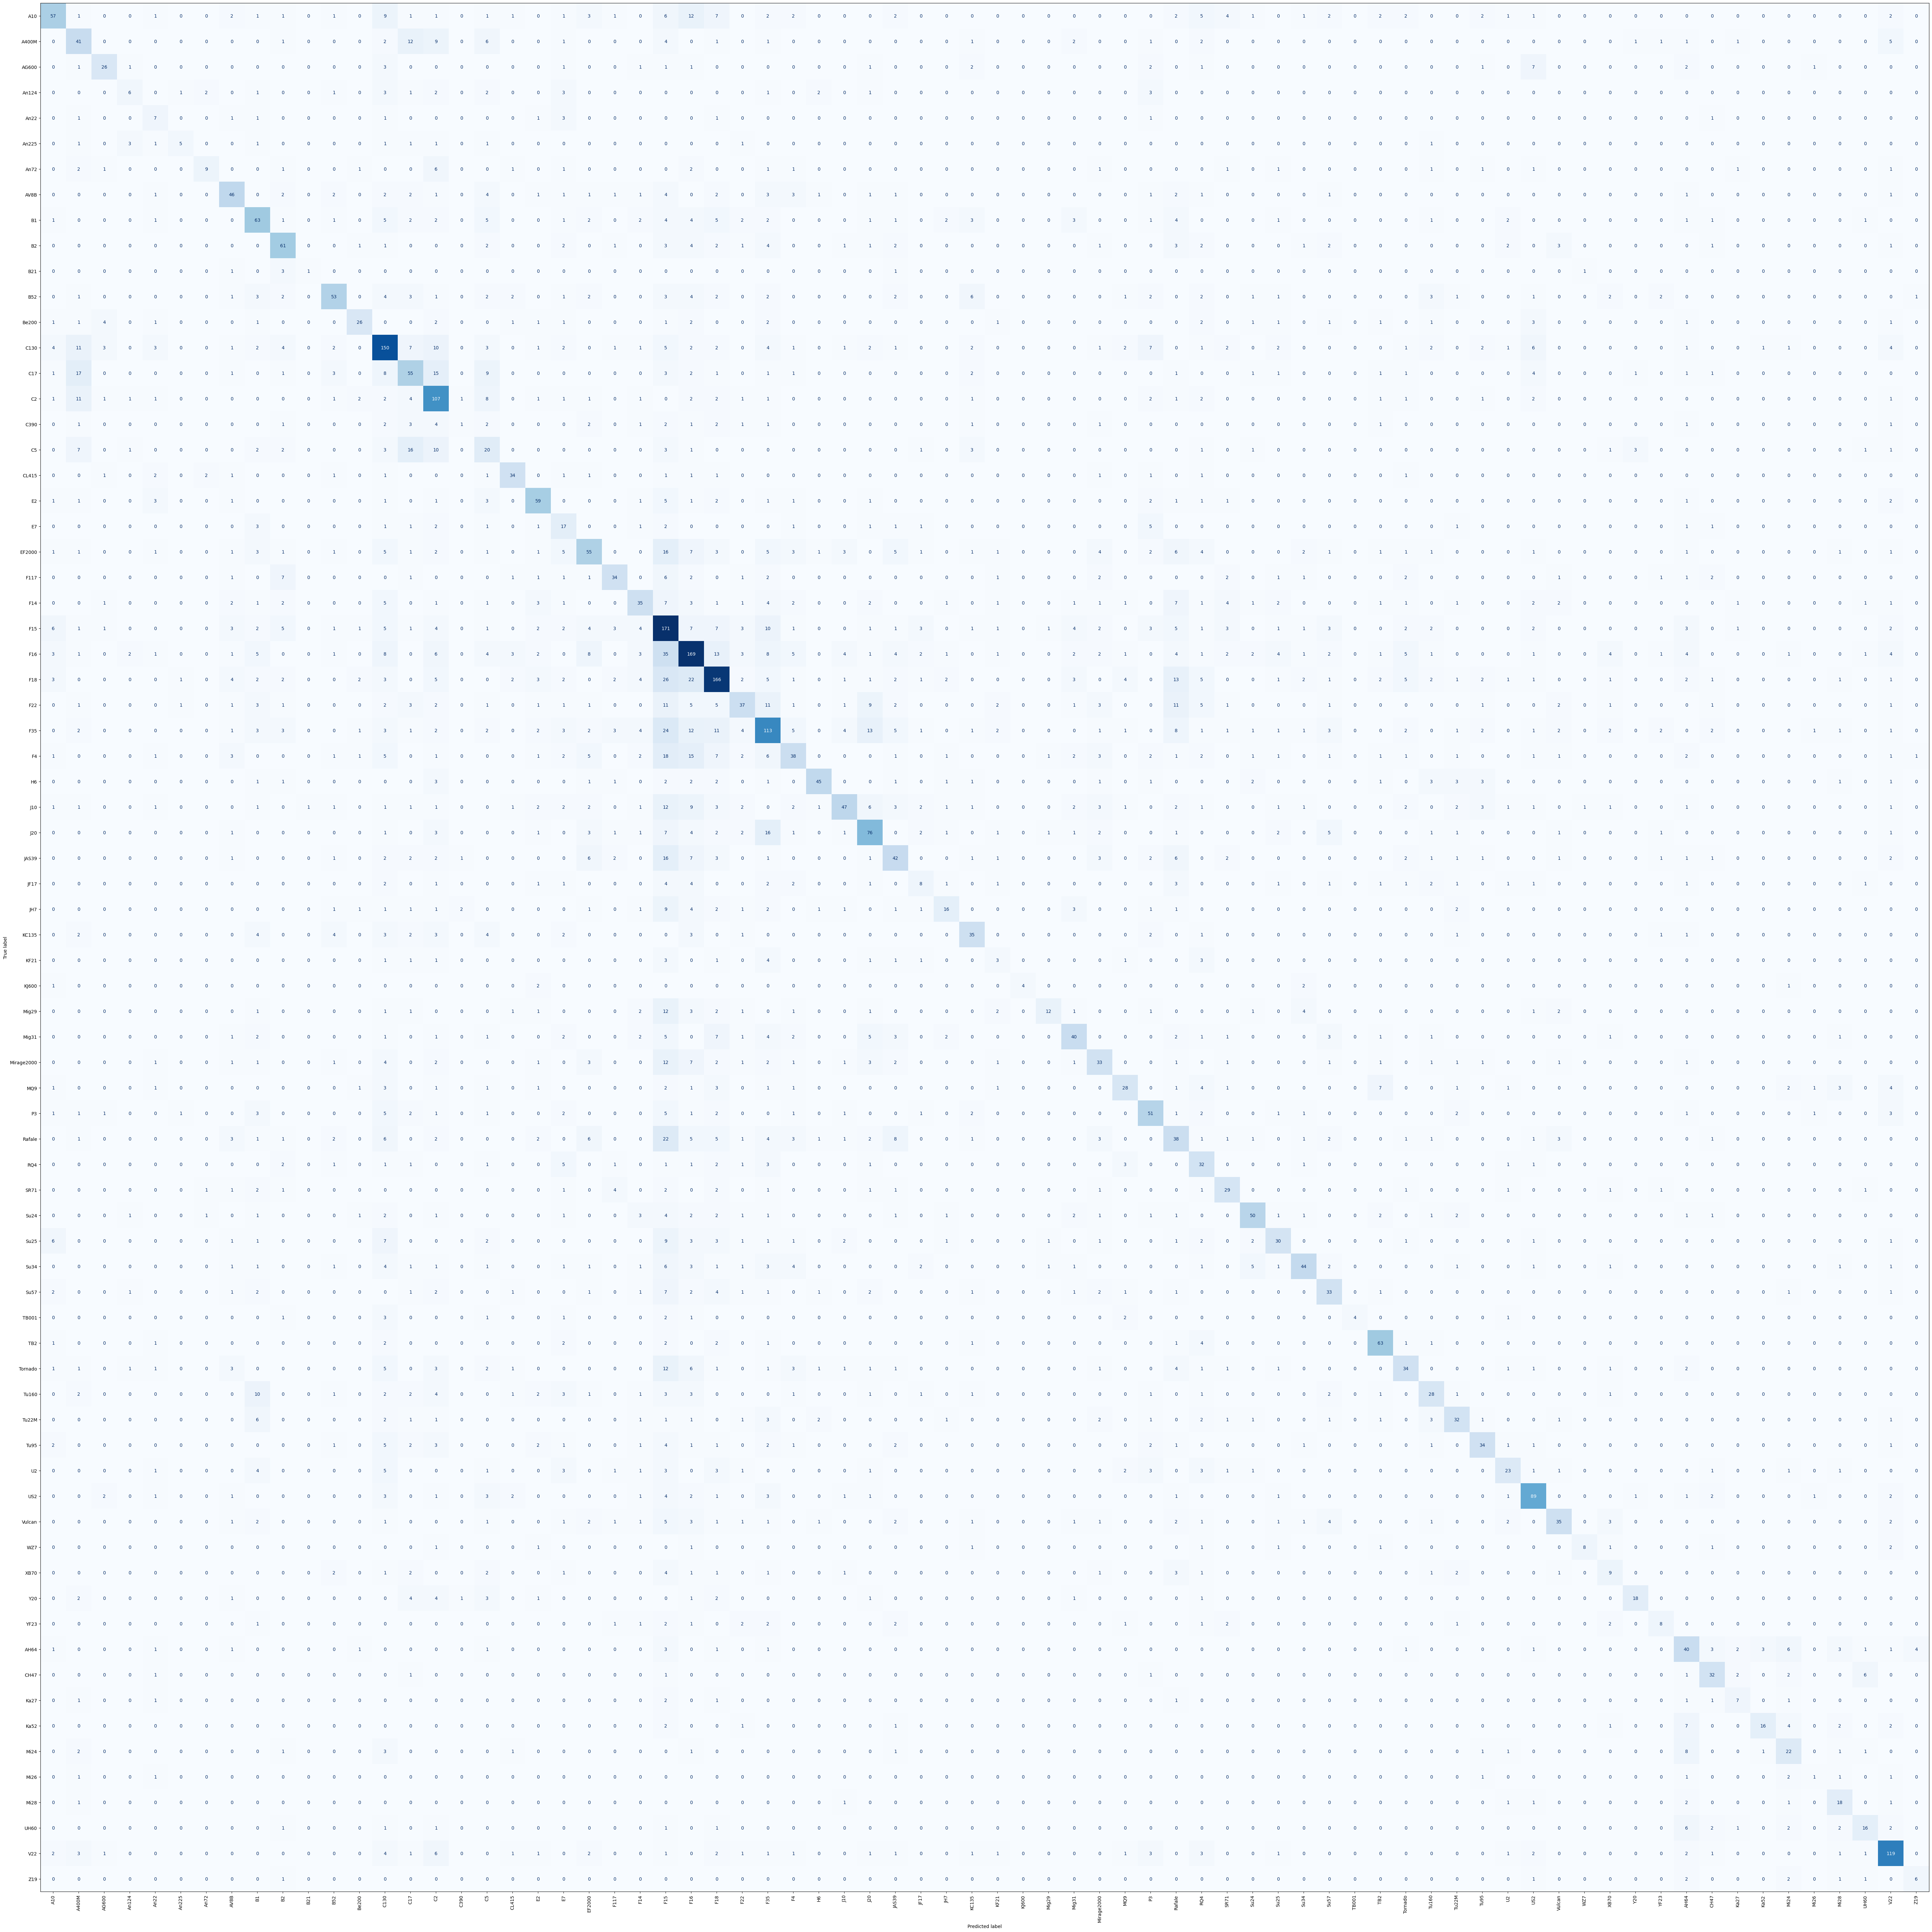

In [16]:
y_true, y_pred = metrics.model_predict(model, val_data)

fig, ax = plt.subplots(figsize=(classes_num, classes_num))
cmp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=class_names, 
    cmap=plt.get_cmap('Blues'),
    colorbar=False, 
    xticks_rotation='vertical', 
    ax=ax
)